In [2]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

from pyod.models.abod import ABOD
from pyod.models.knn import KNN
from pyod.models.iforest import IForest
from pyod.models.cblof import CBLOF
from pyod.models.hbos import HBOS
from pyod.models.ocsvm import OCSVM
from pyod.models.gmm import GMM
from pyod.models.pca import PCA

sns.set_style("darkgrid")

import matplotlib.font_manager

# 2D Outlier Detection

In [3]:
class GetSamplePoints:
    def __init__(self, N=200, outlier_fraction=0.1):
        self.outlier_fraction = outlier_fraction
        self.n_outlier = int(N * self.outlier_fraction)
        self.n_inlier = N - self.n_outlier
        self.run()

    def run_state_machine(self):
        self.inlier_arr = np.random.normal(loc=1.8, scale=0.15, size=(self.n_inlier, 2))
        self.outlier_arr = np.random.uniform(low=0, high=2, size=(self.n_outlier, 2))

        self.X_train = np.concatenate((self.inlier_arr, self.outlier_arr), axis=0)
        self.Y_train = np.concatenate((np.zeros(self.inlier_arr.shape[0]), np.ones(self.outlier_arr.shape[0])),axis=0)

        return self.X_train.T

    def plot_raw_samples(self):
        plt.figure(figsize=(5, 5))
        ax = sns.scatterplot(x=self.F1, y=self.F2)
        ax.set(xlabel="F1", ylabel="F2")
        ax.margins(x=0.12, y=0.12)
        plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)

    def run(self):
        self.F1, self.F2 = self.run_state_machine()

        self.xx, self.yy = np.meshgrid(
            np.linspace(0.0, 2.5, 200), np.linspace(0.0, 2.5, 200)
        )

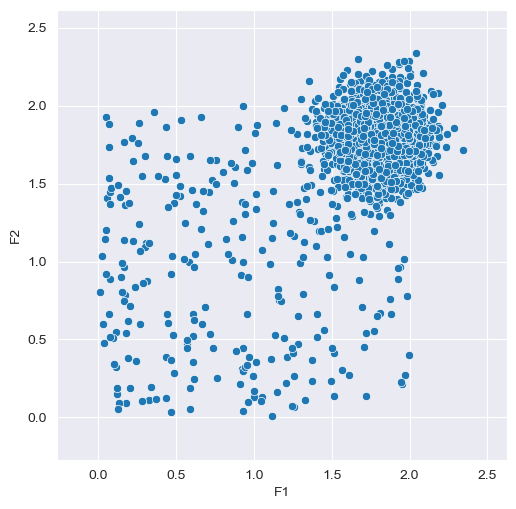

In [4]:
GSP = GetSamplePoints(3000)
GSP.plot_raw_samples()

# Algorithms

In [5]:
class Run2DExperiment:
    def __init__(self, N=200) -> None:
        self.GSP = GetSamplePoints(N)
        self.models = {
            "Angle-based Outlier Detector (ABOD)": ABOD(contamination=self.GSP.outlier_fraction),
            "Gaussian Mixture Model (GMM)": GMM(contamination=self.GSP.outlier_fraction),
            "Isolation Forest": IForest(contamination=self.GSP.outlier_fraction, n_estimators=150),
            "Cluster-based Local Outlier Factor (CBLOF)": CBLOF(contamination=self.GSP.outlier_fraction,n_clusters=10, check_estimator=False),
            "Histogram-base Outlier Detection (HBOS)": HBOS(contamination=self.GSP.outlier_fraction),
            "K Nearest Neighbors (KNN)": KNN(contamination=self.GSP.outlier_fraction),
            "Principle Component Analysis (PCA)": PCA(contamination=self.GSP.outlier_fraction),
            "One Class Support Vector Machine (SVM)": OCSVM(kernel="rbf", degree=3, gamma=0.1, nu=0.99, max_iter=-1),
        }

    def evaluate_model(self, model_name, model):
        # fit the dataset to the model
        model.fit(self.GSP.X_train)

        # predict raw anomaly score
        scores_pred = model.decision_function(self.GSP.X_train) * -1

        # prediction of point category as outlier or inlier
        y_pred = model.predict(self.GSP.X_train)

        # no of errors in prediction
        n_errors = (y_pred != self.GSP.Y_train).sum()
        print("Number of Errors : ", model_name, n_errors)
        return {"scores_pred":scores_pred}

    def create_poster(self):
        plt.figure(figsize=(25, 12.5))

        for i, (model_name, model) in enumerate(self.models.items()) :
            # fit the dataset to the model
            res = self.evaluate_model(model_name, model)

            # threshold value to consider a data point inlier or outlier
            threshold = stats.scoreatpercentile(res["scores_pred"], 100 * self.GSP.outlier_fraction)

            # decision function calculates the raw anomaly score for every point
            Z = model.decision_function(np.c_[self.GSP.xx.ravel(), self.GSP.yy.ravel()]) * -1
            Z = Z.reshape(self.GSP.xx.shape)

            subplot = plt.subplot(2, 4, i + 1)

            # fill blue colormap from minimum anomaly score to threshold value
            subplot.contourf(self.GSP.xx, self.GSP.yy, Z, levels = np.linspace(Z.min(), threshold, 10), cmap=plt.cm.Blues_r)

            # draw red contour line where anomaly score is equal to threshold
            a = subplot.contour(self.GSP.xx, self.GSP.yy, Z, levels=[threshold], linewidths=2, colors='red')

            # fill orange contour lines where range of anomaly score is from threshold to maximum anomaly score
            subplot.contourf(self.GSP.xx, self.GSP.yy, Z, levels=[threshold, Z.max()],colors='orange')

            # scatter plot of inliers with white dots
            b = subplot.scatter(self.GSP.X_train[:-self.GSP.n_outlier, 0], self.GSP.X_train[:-self.GSP.n_outlier, 1], c='white', s=20, edgecolor='k') 
            # scatter plot of outliers with black dots
            c = subplot.scatter(self.GSP.X_train[-self.GSP.n_outlier:, 0], self.GSP.X_train[-self.GSP.n_outlier:, 1], c='black', s=20, edgecolor='k')
            subplot.axis('tight')

            # Create a custom legend
            legend_entries = [
                Line2D([0], [0], linestyle='-', linewidth=2, color='red'),
                Line2D([0], [0], marker='o', color='white', markerfacecolor='white', markersize=5),
                Line2D([0], [0], marker='o', color='black', markerfacecolor='black', markersize=5)
            ]

            subplot.legend(
                legend_entries,
                ['learned decision function', 'true inliers', 'true outliers'],
                prop=matplotlib.font_manager.FontProperties(size=10),
                loc='lower right'
            )

            subplot.set_title(model_name)
            subplot.set_xlim((0.0, 2.5))
            subplot.set_ylim((0.0, 2.5))
        plt.show() 

Number of Errors :  Angle-based Outlier Detector (ABOD) 8
Number of Errors :  Gaussian Mixture Model (GMM) 10
Number of Errors :  Isolation Forest 8
Number of Errors :  Cluster-based Local Outlier Factor (CBLOF) 8
Number of Errors :  Histogram-base Outlier Detection (HBOS) 8
Number of Errors :  K Nearest Neighbors (KNN) 6
Number of Errors :  Principle Component Analysis (PCA) 12
Number of Errors :  One Class Support Vector Machine (SVM) 8


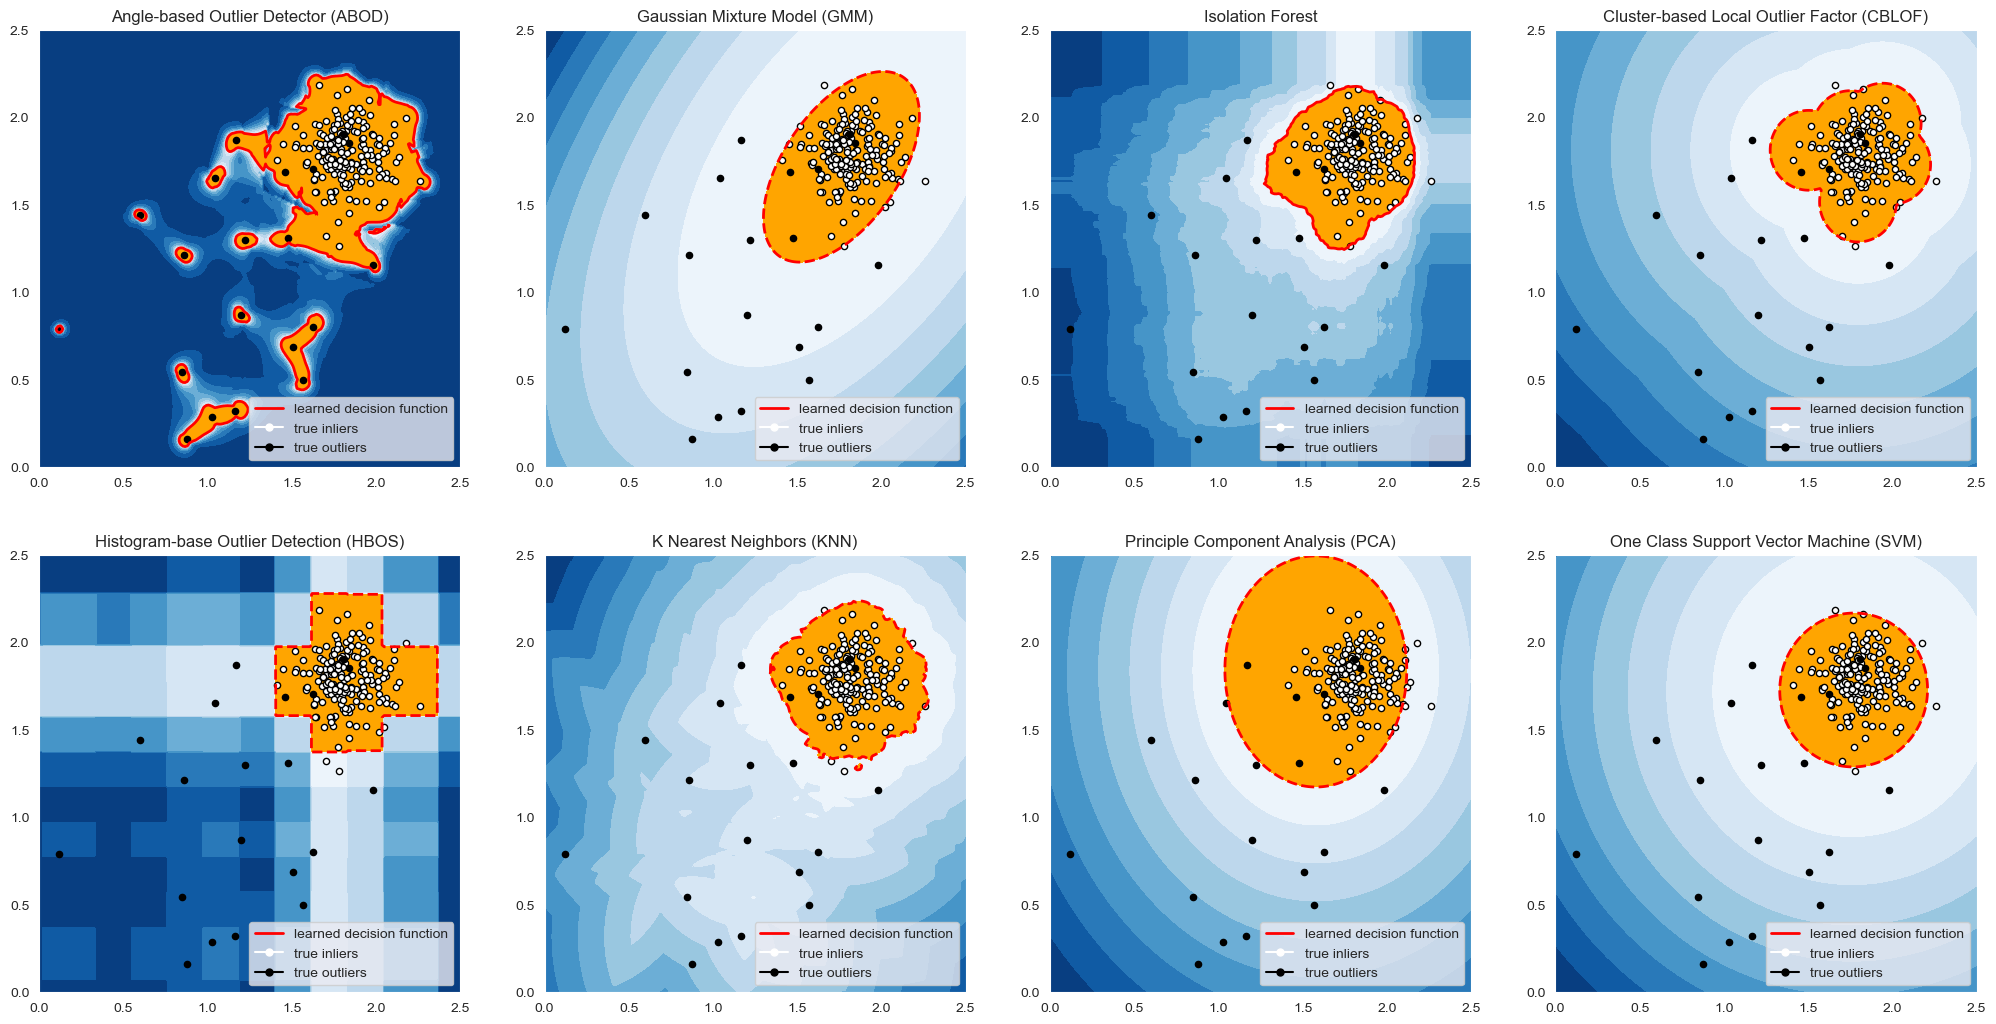

In [6]:
Run2DExperiment(200).create_poster()

Number of Errors :  Angle-based Outlier Detector (ABOD) 79
Number of Errors :  Gaussian Mixture Model (GMM) 64
Number of Errors :  Isolation Forest 52
Number of Errors :  Cluster-based Local Outlier Factor (CBLOF) 48
Number of Errors :  Histogram-base Outlier Detection (HBOS) 74
Number of Errors :  K Nearest Neighbors (KNN) 46
Number of Errors :  Principle Component Analysis (PCA) 92
Number of Errors :  One Class Support Vector Machine (SVM) 54


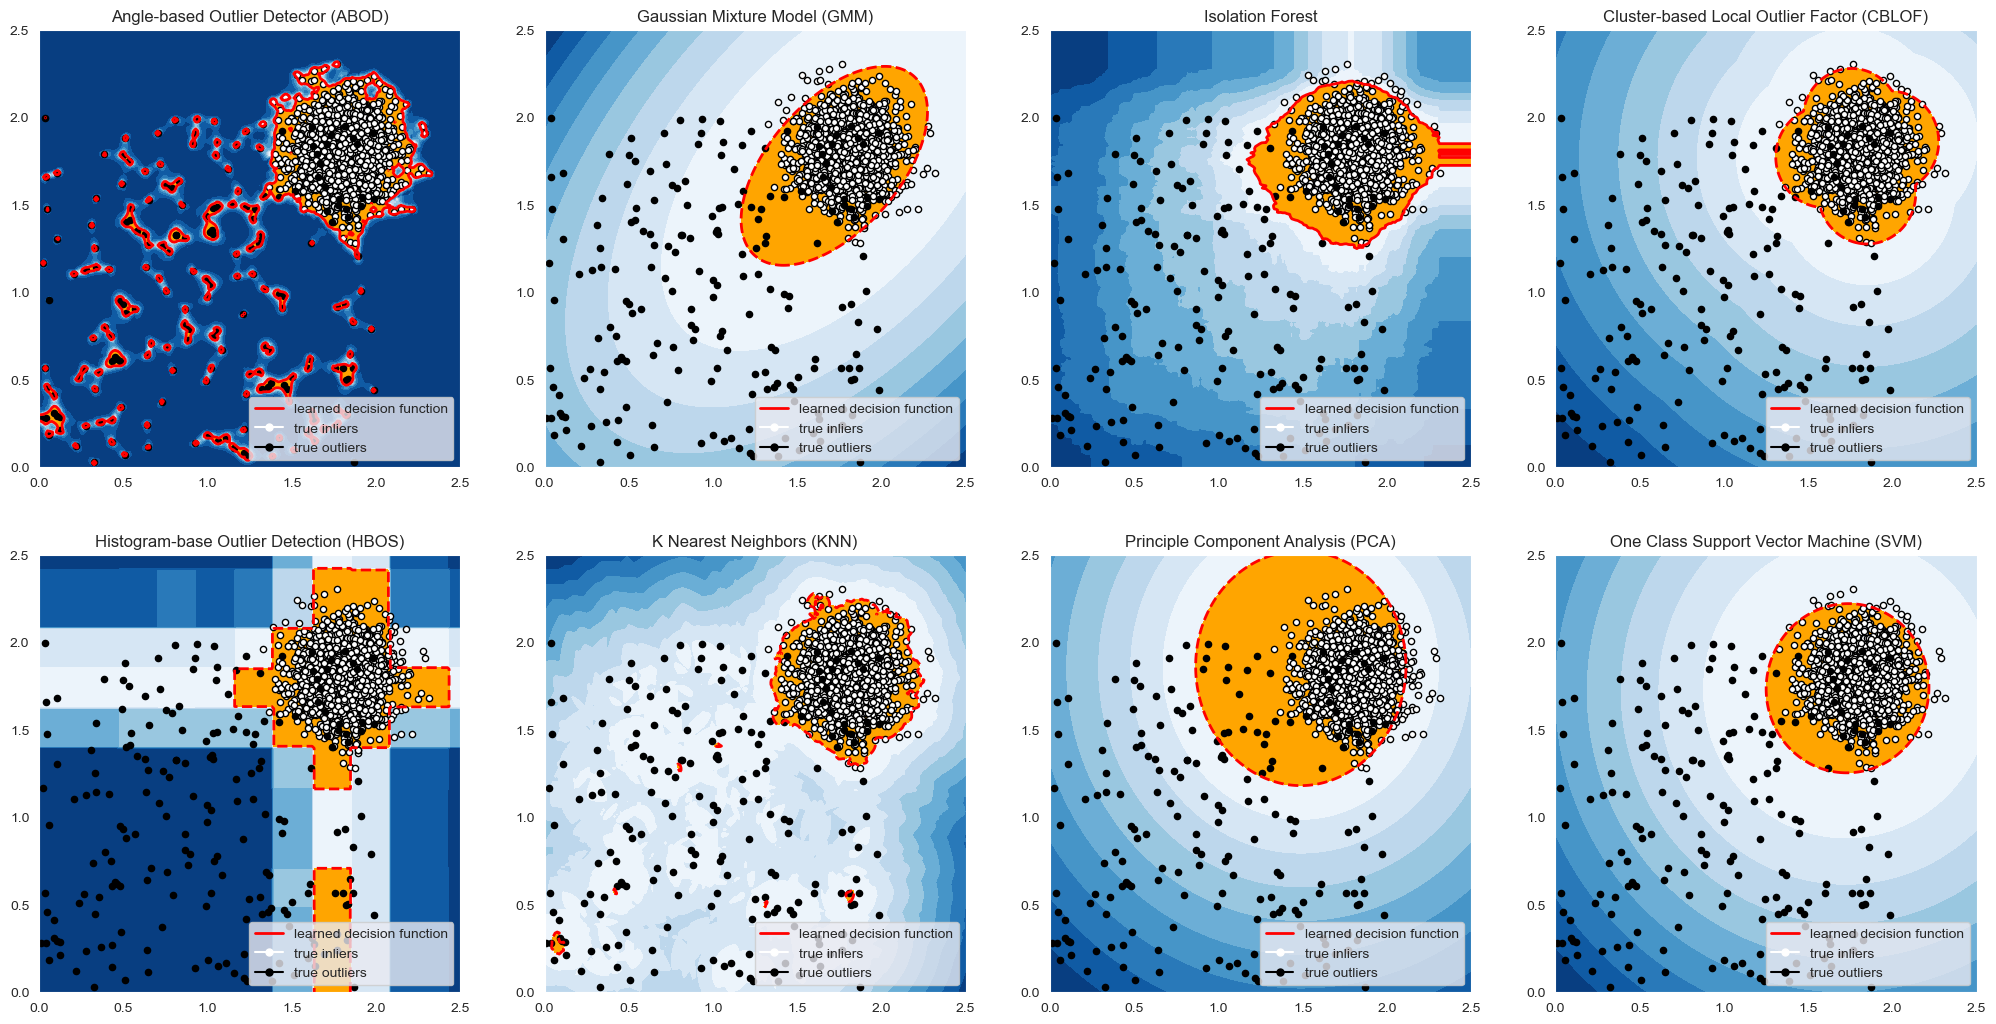

In [7]:
Run2DExperiment(2000).create_poster()